In [54]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import plotly.offline as offline
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
from plotly.graph_objs import *
from plotly import tools

## 读取数据集

In [5]:
data = pd.read_csv('adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [6]:
data.shape

(32561, 15)

In [7]:
print('<=50K', len(data[data['income'] == '<=50K']))
print('>50k', len(data[data['income'] == '>50K']))

<=50K 24720
>50k 7841


## 数据预处理

### 数字化类别数据

In [8]:
for feature in data.columns:
    if data[feature].dtype == 'object':
        data[feature] = pd.Categorical(data[feature]).codes
        
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,0,77053,11,9,6,0,1,4,0,0,4356,40,39,0
1,82,4,132870,11,9,6,4,1,4,0,0,4356,18,39,0
2,66,0,186061,15,10,6,0,4,2,0,0,4356,40,39,0
3,54,4,140359,5,4,0,7,4,4,0,0,3900,40,39,0
4,41,4,264663,15,10,5,10,3,4,0,0,3900,40,39,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null int8
fnlwgt            32561 non-null int64
education         32561 non-null int8
education.num     32561 non-null int64
marital.status    32561 non-null int8
occupation        32561 non-null int8
relationship      32561 non-null int8
race              32561 non-null int8
sex               32561 non-null int8
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null int8
income            32561 non-null int8
dtypes: int64(6), int8(9)
memory usage: 1.8 MB


### 选取特征数据与类别数据

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_df = data.iloc[:, data.columns != 'income']
y_df = data.iloc[:, data.columns == 'income']

X = np.array(X_df)
y = np.array(y_df)

### 标准化数据

In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### 特征选取

#### 特征重要性评估

在这里我们使用决策树分类器来判断特征变量的重要性

In [28]:
from sklearn.tree import DecisionTreeClassifier

# 给原数据生成一个额外的模型
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X, y)

# 显示每个属性的相对重要性得分
relval = tree.feature_importances_

#### 图示特征重要性

In [38]:
colors = ['#e43620', '#f16d30','#d99a6c','#fed976', '#b3cb95', '#41bfb3','#229bac', 
'#256894', '#fed936', '#f36d30', '#b3cb25', '#f14d30','#49bfb5','#252bac',]

trace = Bar(x = X_df.columns.tolist(), y = relval, text = [round(i,2) for i in relval], textposition= "outside", marker = dict(color = colors))
iplot(Figure(data = [trace], layout = Layout(title="特征重要性", width = 800, height = 400, yaxis = dict(range = [0,0.25]))))

### 递归特征消除

In [41]:
from sklearn.feature_selection import RFE

# 使用决策树作为模型
lr = DecisionTreeClassifier()
names = X_df.columns.tolist()

# 将所有特征排序
selector = RFE(lr, n_features_to_select = 10)
selector.fit(X, y.ravel())

print('排序后的特征：', sorted(zip(map(lambda x: round(x, 4), selector.ranking_), names)))

排序后的特征： [(1, 'age'), (1, 'capital.gain'), (1, 'capital.loss'), (1, 'education.num'), (1, 'fnlwgt'), (1, 'hours.per.week'), (1, 'native.country'), (1, 'occupation'), (1, 'relationship'), (1, 'workclass'), (2, 'race'), (3, 'education'), (4, 'marital.status'), (5, 'sex')]


In [42]:
# 得到新的 dataframe
X_df_new = X_df.iloc[:, selector.get_support(indices = False)]
X_df_new.columns

Index(['age', 'workclass', 'fnlwgt', 'education.num', 'occupation',
       'relationship', 'capital.gain', 'capital.loss', 'hours.per.week',
       'native.country'],
      dtype='object')

### 将特征选取后的数据标准化

In [43]:
X_new = scaler.fit_transform(np.array(X_df_new))

### 训练集与测试集切分

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y)

### 建模和评估

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, classification_report

import matplotlib.pyplot as plt
import itertools

#### 绘制混淆矩阵

In [45]:
def plot_confusion_matrix(cm, classes,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment = 'center',
                color = 'white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 逻辑回归

In [48]:
lr = LogisticRegression()
lr_clf = lr.fit(X_train, y_train.ravel())
y_pred = lr_clf.predict(X_test)

print('LogisticRegression %s' % metrics.accuracy_score(y_test, y_pred))

LogisticRegression 0.8243459034516644


#### 绘制混淆矩阵

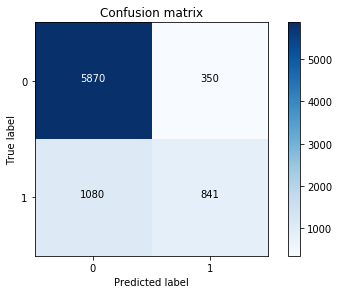

In [49]:
cm = confusion_matrix(y_test, y_pred)

class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm, classes = class_names, title = 'Confusion matrix')
plt.show()

### 朴素贝叶斯

In [51]:
gnb = GaussianNB()
gnb_clf = gnb.fit(X_train, y_train.ravel())
y_pred2 = gnb_clf.predict(X_test)

print('GaussianNB %s' % metrics.accuracy_score(y_test, y_pred2))

GaussianNB 0.8034639479179462


#### 绘制混淆矩阵

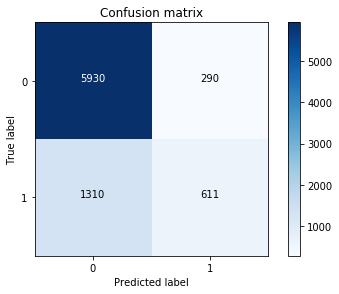

In [53]:
cm = confusion_matrix(y_test, y_pred2)

class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm, classes = class_names, title = 'Confusion matrix')
plt.show()